### YOLOV3 object detection

In this example, I will inplememnt YOLOV3 object detection using OpenCV and the pretrained DarkNet model, provided by the author of YOLO. The model is trained using the COCO dataset.

In [131]:
import os.path
import cv2
import numpy as np
import pandas as pd

import requests
from matplotlib import pyplot as plt
from pathlib import PosixPath

In [5]:
# Download YOLO net config file
# We'll it from the YOLO author's github repo

yolo_config = PosixPath("../data/yolov3.cfg")
if not yolo_config.is_file():
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
    r = requests.get(url)
    yolo_config.write_bytes(r.content)

# Download YOLO net weights
# We'll it from the YOLO author's website
yolo_weights = PosixPath("../data/yolov3.weights")
if not os.path.isfile(yolo_weights):
    url = 'https://pjreddie.com/media/files/yolov3.weights'
    r = requests.get(url)
    yolo_weights.write_bytes(r.content)

## Model instantiate with OpenCV

In [10]:
net = cv2.dnn.readNet(str(yolo_weights), str(yolo_config))

## Next, we'll download and load the COCO class names, so we'll know what the algorithm output is:

In [11]:
classes_file = PosixPath('../data/coco.names')
if not classes_file.is_file():
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
    r = requests.get(url)
    classes_file.write_bytes(r.content)

In [34]:
with open(classes_file, 'r') as f:
    classes = [ name.strip() for name in f.read().split()]

In [36]:
classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic',
 'light',
 'fire',
 'hydrant',
 'stop',
 'sign',
 'parking',
 'meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports',
 'ball',
 'kite',
 'baseball',
 'bat',
 'baseball',
 'glove',
 'skateboard',
 'surfboard',
 'tennis',
 'racket',
 'bottle',
 'wine',
 'glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot',
 'dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell',
 'phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy',
 'bear',
 'hair',
 'drier',
 'toothbrush']

In [122]:
image_file = "dora.png"
image = cv2.imread(image_file)
blob = cv2.dnn.blobFromImage(image, 1 / 255, (416, 416), (0, 0, 0), True, crop=False)

In [123]:
# set as input to the net
net.setInput(blob)

# get network output layers
layer_names = net.getLayerNames()

In [124]:
# get network output layers
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [125]:
# inference
# the network outputs multiple lists of anchor boxes,
# one for each detected class
outs = net.forward(output_layers)

In [126]:
len(outs), [out.shape for out in outs]

(3, [(507, 85), (2028, 85), (8112, 85)])

Then, we'll pre-process the network outputs and we'll apply non-max suppression over them to produce the final set of detected objects:

In [127]:
# extract bounding boxes
class_ids = list()
confidences = list()
boxes = list()

# iterate over all classes
for out in outs:
    ## for every grid
    for detection in out:
        center_x = int(detection[0] * image.shape[1])
        center_y = int(detection[1] * image.shape[0])
        w, h = int(detection[2] * image.shape[1]), int(detection[3] * image.shape[0])
        x, y = center_x - w // 2, center_y - h // 2
        boxes.append([x, y, w, h])
        
        # confidence
        confidences.append(float(detection[4]))

        # class
        class_ids.append(np.argmax(detection[5:]))

# non-max suppression
ids = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.02, nms_threshold=0.5)

In [128]:
len(ids)

2

Next, we'll plot each bounding box and class label over the input image:

In [129]:
# draw the bounding boxes on the image
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# iterate over all boxes
for i in ids:
    i = i[0]
    x, y, w, h = boxes[i]
    class_id = class_ids[i]

    color = colors[class_id]

    cv2.rectangle(img=image,
                  pt1=(round(x), round(y)),
                  pt2=(round(x + w), round(y + h)),
                  color=color,
                  thickness=3)

    cv2.putText(img=image,
                text=f"{classes[class_id]}: {confidences[i]:.2f}",
                org=(x - 10, y - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.8,
                color=color,
                thickness=2)

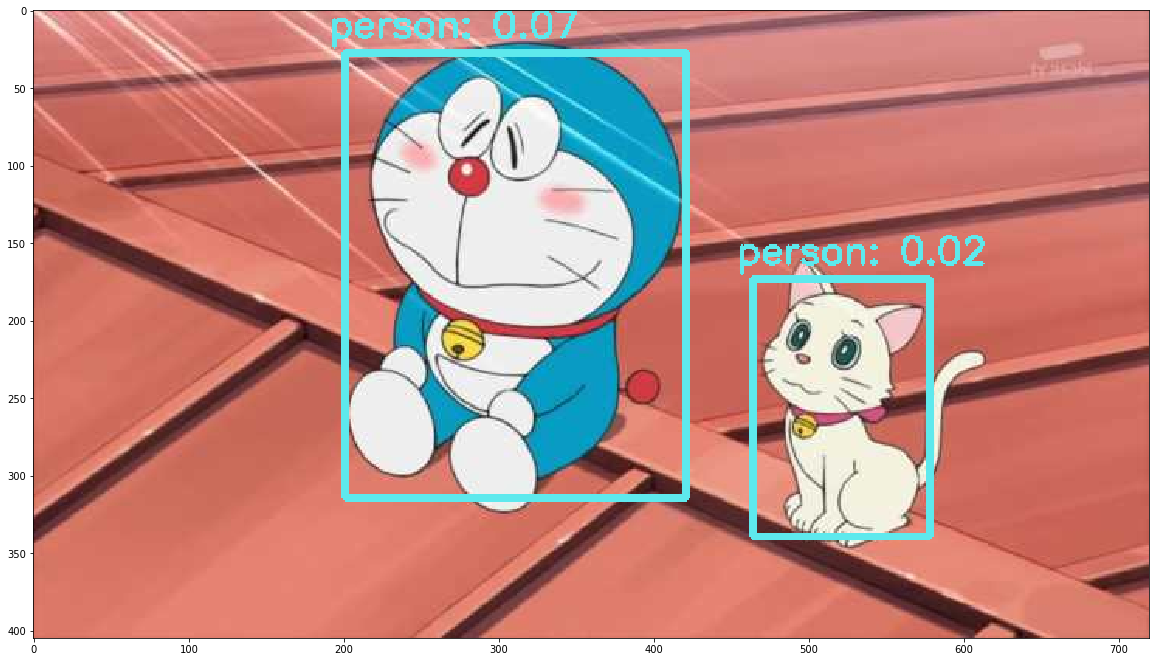

In [130]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))